## NeuroAlign - Inference

This notebook can be used to predict alignments from fasta files of unaligned sequences using a pretrained NeuroAlign model.

NeuroAlign is a deep learning based end-to-end model that is able to construct multiple sequence alignments by supervised learning of reference alignments. Our model maps raw sequences
\- for instance over the standard aminoacid alphabet but not limited to that \- to a soft alignment represented by a membership probablity for each residuum and each alignment column in a (dynamically sized) consensus sequence. NeuroAlign can also output representation vectors for the alignment columns which encode the respective distribution of aminoacids that can be useful for higher level learning tasks.

The weight files provided with this notebook are trained on Pfam. We used all 18259 protein families available at the time of our access, but only their respective seed alignments.

### Requirements

This notebook requires tensorflow (2.1 or higher) and matplotlib. Other than that, it is self-contained. 

Model weight files are provided with github under ./models.

If a GPU is present, the notebook will automatically attempt to use it. 

## Setting up the model

We provide configurated and pretrained "out of the box" models. All what has to be done is to load a model using its identifier.

In [1]:
import Model as model

neuroalign, neuroalign_config = model.make_neuro_align_model("base2")

Successfully loaded weights: base2 model


## Loading a fasta file
NeuroAlign operates on raw sequences of aminoacids in fasta file format. Sequences can come in any number and order. The model is inherently invariant to permuntations of the sequences. 

We first parse the fasta files and convert to a numeric "one-hot" format which can be passed to the NeuroAlign model. 

In [2]:
import sys
import Data as data

#######################################################################################
################ you may modify these variables to test NeuroAlign ####################
#######################################################################################

file = "./data/BB11002.fasta"

# set this to True, if the fasta file is already aligned 
# i.e. it contains gap symbols and all sequences have the same length
# if True, the gap symbols will be automatically stripped away before inference and will
# only be used for evaluating the model output
# if False, the model will just compute its output and skip all evaluation
has_gaps = True 

#######################################################################################
#######################################################################################
#######################################################################################

fasta_file = data.Fasta(file, gaps = has_gaps, contains_lower_case = True)

if not fasta_file.valid:
    sys.exit("Invalid fasta file.")

selected_sequences = list(range(len(fasta_file.raw_seq))) #all and in order
if has_gaps:
    input_dict, target_dict = data.get_input_target_data(fasta_file, selected_sequences, neuroalign_config)
else:
    seq = fasta_file.one_hot_sequences(selected_sequences)
    input_dict = {"sequences" : seq}
    
print("Successfully loaded file:", file)

Successfully loaded file: ./data/BB11002.fasta


In [3]:
print("Alphabet:",list(enumerate(data.ALPHABET)))

seq_i = 0
print("begin of sequence "+str(seq_i)+":")
print("$" + fasta_file.aminoacid_seq_str(seq_i)[:4]) #each sequence is preceeded by a gap dummy "_" followed by the start-marker $
print(input_dict["sequences"][seq_i,:6])

col_i = 3
if has_gaps:
    print("column "+str(col_i)+":")
    print(fasta_file.column_str(col_i))
    print(target_dict["out_columns"][col_i])

Alphabet: [(0, 'A'), (1, 'R'), (2, 'N'), (3, 'D'), (4, 'C'), (5, 'Q'), (6, 'E'), (7, 'G'), (8, 'H'), (9, 'I'), (10, 'L'), (11, 'K'), (12, 'M'), (13, 'F'), (14, 'P'), (15, 'S'), (16, 'T'), (17, 'W'), (18, 'Y'), (19, 'V'), (20, 'B'), (21, 'Z'), (22, 'X'), (23, 'U'), (24, 'O')]
begin of sequence 0:
$NLFV
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
column 3:
-L------
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.125 0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.

NeuroAlign is an autoregressive model that predicts a consensus sequence of columns one at a time conditioned on the input sequences and all previous columns. Its decision for the aminoacid distribution of a column is based on all sequences and all previously predicted columns. Inference internally starts with a consensus consisting only of a special "column start" marker. It is then rolled out autoregressively in order to generate columns until a "column end" marker is predicted or a maximal length (default 1000) is reached.

We provide a method for generating the columns this way.

In [4]:
# generates a 2D tensor "column_distributions" with shape [num_columns, alphabet_size]
# and a 3D tensor "attention_weights" with shape [num_seq, len_seq, num_cols]
column_distributions, attention_weights = model.gen_columns(input_dict, neuroalign, neuroalign_config)

print("Prediction run on file", fasta_file.filename, "with", len(fasta_file.raw_seq), 
      "sequences of average length", sum(fasta_file.seq_lens) / len(fasta_file.raw_seq), ".")
print("Predicted a soft alignment with", column_distributions.shape[0], "columns.")
if has_gaps:
    print("The reference has", fasta_file.alignment_len, "columns.")

Prediction run on file ./data/BB11002.fasta with 8 sequences of average length 98.0 .
Predicted a soft alignment with 125 columns.
The reference has 234 columns.


## Evaluation

So far, a soft alignment was predicted and we seek to evaluate it. NeuroAlign uses an attention mechanism that measures the degree of importance of a residuum to a particular column. A good way to visualize the prediction is to plot the attention weights. This way, we can make a visual comparison of the reference alignment with the predicted attention scores. NeuroAlign is trained in a way such that as much homologous residues from the reference are aligned in the prediction as possible. Thus, they may share a column in the prediction that has a different index in the reference.

Furthermore, we need a way to evaluate the models performance in terms of numeric metrics. To that end, we compute precision and recall for all binary variables "residue X and residue Y are aligned".

alignment precision:  0.40150565
alignment recall:  0.15403129
alignment precision (teacher forced):  0.46178412
alignment recall (teacher forced):  0.26101083
teacher forced KLD:  0.893517
teacher forced one out KLD for A : 0.8755514
teacher forced one out KLD for R : 0.8871489
teacher forced one out KLD for N : 0.88430655
teacher forced one out KLD for D : 0.886169
teacher forced one out KLD for C : 0.8823515
teacher forced one out KLD for Q : 0.8817945
teacher forced one out KLD for E : 0.89156866
teacher forced one out KLD for G : 1.6957511
teacher forced one out KLD for H : 0.886648
teacher forced one out KLD for I : 0.8823625
teacher forced one out KLD for L : 0.88711643
teacher forced one out KLD for K : 0.8794125
teacher forced one out KLD for M : 0.8812295
teacher forced one out KLD for F : 0.8757198
teacher forced one out KLD for P : 1.7356781
teacher forced one out KLD for S : 0.8720526
teacher forced one out KLD for T : 0.8797693
teacher forced one out KLD for W : 0.8696669

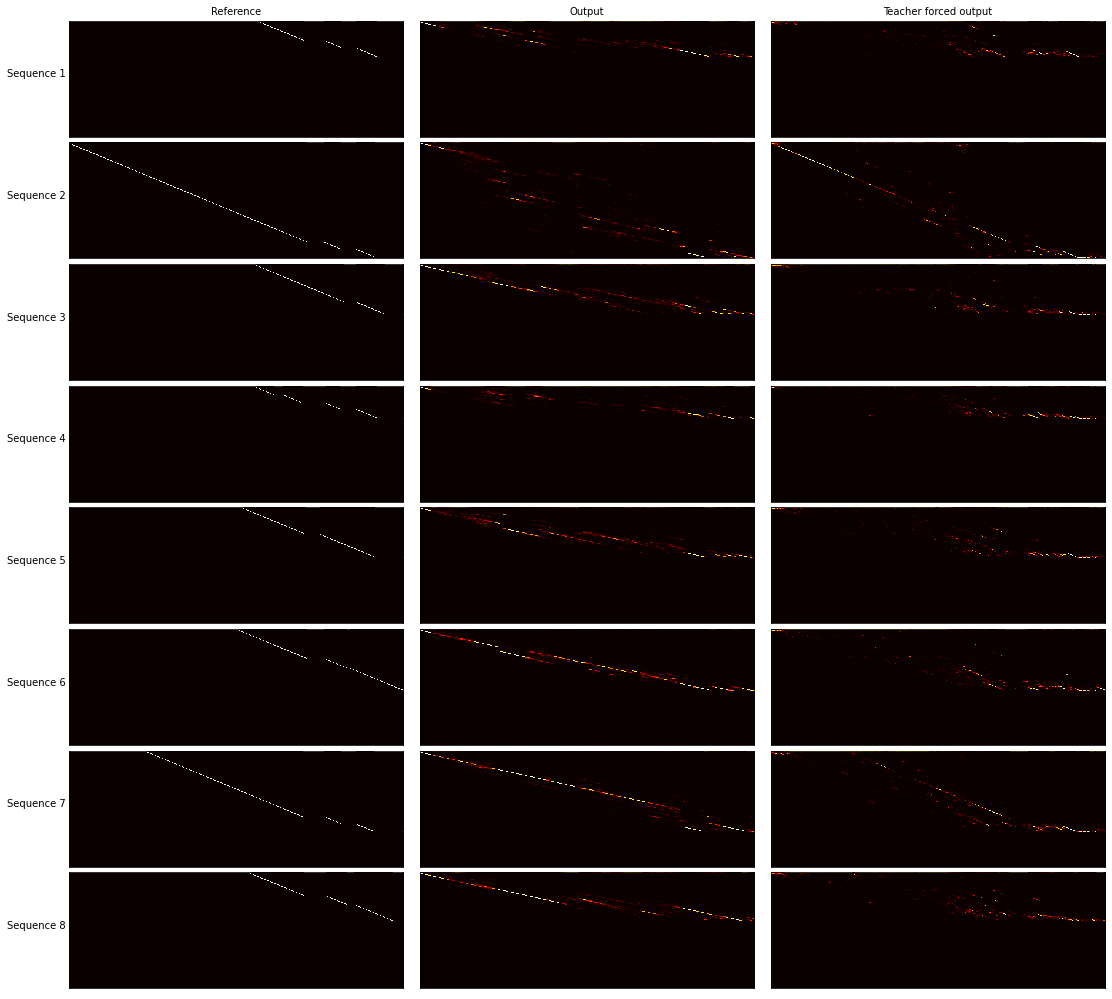

In [7]:
import Evaluation as evl

#for comparison compute the output with teacher forcing enabled
#i.e. when predicting column i the model knowns how reference columns 1...i-1 look like
teacher_forced_column_distributions, teacher_forced_attention_weights = neuroalign(input_dict)

def flip(x):
    return np.transpose(x, [0,2,1])

evl.plot_memberships(flip(target_dict["out_attention"]), [flip(attention_weights),flip(teacher_forced_attention_weights)], ["Output", "Teacher forced output"])

p = evl.precision(target_dict["out_attention"], attention_weights).numpy()
r = evl.recall(target_dict["out_attention"], attention_weights).numpy()

print("alignment precision: ", p)
print("alignment recall: ", r)


p = evl.precision(target_dict["out_attention"], teacher_forced_attention_weights).numpy()
r = evl.recall(target_dict["out_attention"], teacher_forced_attention_weights).numpy()

print("alignment precision (teacher forced): ", p)
print("alignment recall (teacher forced): ", r)


print("teacher forced KLD: ", evl.kld(target_dict["out_columns"], teacher_forced_column_distributions).numpy())
alphabet = data.ALPHABET + ["_", "$", "#"]
for i in range(len(alphabet)):
    l = evl.one_out_kld(i)(target_dict["out_columns"], teacher_forced_column_distributions).numpy()
    print("teacher forced one out KLD for", alphabet[i], ":", l)